In [22]:
!apt-get install -y tesseract-ocr
!pip install pytesseract opencv-python-headless
!apt-get install tesseract-ocr


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


Saving id7.png to id7 (8).png


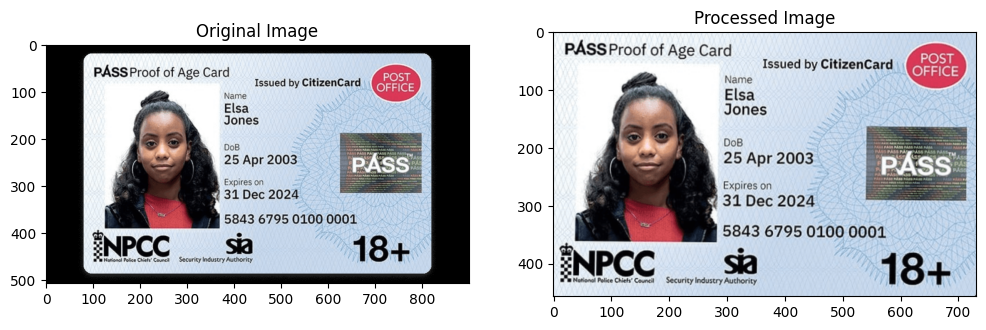

In [146]:
##1
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from google.colab import files
from google.colab.patches import cv2_imshow
import pandas as pd
import re
from sklearn.metrics import accuracy_score
uploaded = files.upload()

for fn in uploaded.keys():
    image_path = fn

image = cv2.imread(image_path)

if image is None:
    raise ValueError("not found")

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (7, 7), 0)

    edges = cv2.Canny(blurred, 50, 200)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours = [c for c in contours if cv2.contourArea(c) > 5000]

    if len(contours) == 0:
        print("لم يتم العثور على الحواف المناسبة.")
        return image

    largest_contour = max(contours, key=cv2.contourArea)

    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)

    if len(approx) == 4:
        pts = approx.reshape(4, 2)
        rect = np.zeros((4, 2), dtype="float32")

        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]

        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]

        (tl, tr, br, bl) = rect
        widthA = np.linalg.norm(br - bl)
        widthB = np.linalg.norm(tr - tl)
        maxWidth = max(int(widthA), int(widthB))

        heightA = np.linalg.norm(tr - br)
        heightB = np.linalg.norm(tl - bl)
        maxHeight = max(int(heightA), int(heightB))

        if maxWidth > image.shape[1] * 0.4 and maxHeight > image.shape[0] * 0.4:
            dst = np.array([
                [0, 0],
                [maxWidth - 1, 0],
                [maxWidth - 1, maxHeight - 1],
                [0, maxHeight - 1]], dtype="float32")

            M = cv2.getPerspectiveTransform(rect, dst)
            warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

            return warped
        else:
            print("soo small")
            return image
    else:
        print("not found")
        return image

processed_image = preprocess_image(image)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Processed Image')
plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
plt.show()


In [147]:
##2

def extract_text_from_image(image):
    custom_config = r'--oem 3 --psm 6'
    text = pytesseract.image_to_string(image, config=custom_config)
    return text
preprocessed_image = preprocess_image(image)

if preprocessed_image is not None:
    extracted_text = extract_text_from_image(preprocessed_image)
    print("النص المستخرج:")
    print(extracted_text)

else:
    print("لم يتم معالجة الصورة بشكل صحيح.")

النص المستخرج:
PASS Proof of Age Card :
Issued by CitizenCard
4 Name
oon Elsa
Jones
‘S 2) DoB ioe
feos 25 Apr 2003 Bee Noto
Expires on Se
= 31 Dec 2024 3
Se 5843 6795 0100 0001
we, e
ENPCC _ Sia 18+



In [148]:
###3
import re
import pandas as pd

def extract_info(text):
    info = {}

    cleaned_text = re.sub(r'[^\w\s]', ' ', text)
    lines = cleaned_text.split('\n')
    name_parts = []
    name_started = False

    for line in lines:
        line = line.strip()
        if not line:
            continue

        if re.search(r'\bName\b', line, re.IGNORECASE):
            name_started = True
            continue

        if name_started:
            words = re.findall(r'\b[A-Z][a-z]*\b', line)
            if words:
                name_parts.extend(words)

                if len(name_parts) >= 2:
                    break

    full_name = ' '.join(name_parts)
    full_name_cleaned = re.sub(r'\s+', ' ', full_name).strip()

    info['Name'] = full_name_cleaned if full_name_cleaned else 'Not Found'

    dob_patterns = [
        r'\b\d{2}[\s/-]\w{3}[\s/-]\d{4}\b',  # 01 Jan 1990
        r'\b\d{4}[\s/-]\d{2}[\s/-]\d{2}\b',  # 1990-01-01
        r'\b\d{2}/\d{2}/\d{4}\b',  # 01/01/1990
        r'\b\w{3} \d{2}, \d{4}\b',  # Jan 01, 1990
        r'\b\d{2}\s\w{3}\s\d{4}\b'  # 14 Jan 1996
    ]

    dob_match = None
    for pattern in dob_patterns:
        dob_match = re.search(pattern, text)
        if dob_match:
            break

    info['Date of Birth'] = dob_match.group(0).strip() if dob_match else 'Not Found'

    card_patterns = [
        r'\b\d{4}[\s-]?\d{4}[\s-]?\d{4}[\s-]?\d{4}\b',  # 1234 5678 9012 3456 or 1234567890123456
        r'\b\d{16}\b',  # 1234567890123456
        r'\b\d{4}[\s-]?\d{4}[\s-]?\d{4}[\s-]?\d{4}[\s-]?\d{4}\b',  # Extended formats
        r'\b\d{4} \d{4} \d{4} \d{4}\b'  # 1234 5678 9012 3456
    ]

    id_match = None
    for pattern in card_patterns:
        id_match = re.search(pattern, text)
        if id_match:
            break

    info['ID Number'] = id_match.group(0).strip() if id_match else 'Not Found'

    return info

info_dict = extract_info(extracted_text)

df = pd.DataFrame([info_dict])
print(df)



         Name Date of Birth            ID Number
0  Elsa Jones   25 Apr 2003  5843 6795 0100 0001


In [149]:
known_data = [
    {'Name': 'Elsa Jones', 'Date of Birth': '25 Apr 2003', 'ID Number': '5843 6795 0100 0001'}
]
known_df = pd.DataFrame(known_data)
merged_df = pd.merge(df, known_df, on=["Name", "Date of Birth", "ID Number"], how="outer", indicator=True)
total_records = len(known_df)
matched_records = len(merged_df[merged_df['_merge'] == 'both'])
match_percentage = (matched_records / total_records) * 100

print(f"نسبة التطابق: {match_percentage:.2f}%")
print("بيانات تطابق النتائج:")
print(merged_df[merged_df['_merge'] == 'both'])

print("\nبيانات النتائج التي لم تتطابق:")
print(merged_df[merged_df['_merge'] != 'both'])



نسبة التطابق: 100.00%
بيانات تطابق النتائج:
         Name Date of Birth            ID Number _merge
0  Elsa Jones   25 Apr 2003  5843 6795 0100 0001   both

بيانات النتائج التي لم تتطابق:
Empty DataFrame
Columns: [Name, Date of Birth, ID Number, _merge]
Index: []


In [ ]:

#anther example



Saving id5.jpg to id5 (7).jpg


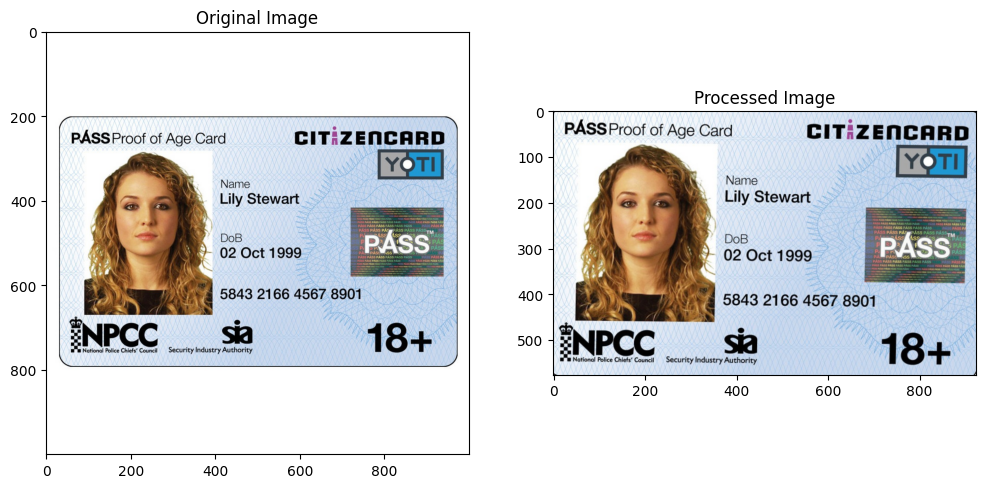

In [150]:
##1
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from google.colab import files
from google.colab.patches import cv2_imshow
import pandas as pd
import re
from sklearn.metrics import accuracy_score

uploaded = files.upload()

for fn in uploaded.keys():
    image_path = fn

image = cv2.imread(image_path)

if image is None:
    raise ValueError("not found.")

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # تطبيق التمويه الغاوسي لتقليل الضوضاء
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)

    # استخدام كشف الحواف Canny مع قيم مختلفة
    edges = cv2.Canny(blurred, 50, 200)

    # العثور على الحواف
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # تصفية الحواف بناءً على المساحة (اختيار أكبر الحواف)
    contours = [c for c in contours if cv2.contourArea(c) > 5000]

    if len(contours) == 0:
        print("لم يتم العثور على الحواف المناسبة.")
        return image  # عرض الصورة الأصلية إذا لم يتم العثور على حواف مناسبة

    # العثور على الحافة ذات أكبر مساحة
    largest_contour = max(contours, key=cv2.contourArea)

    # استخدام تقريب متعدد الأضلاع لإيجاد الزوايا الأربع
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)

    if len(approx) == 4:
        pts = approx.reshape(4, 2)
        rect = np.zeros((4, 2), dtype="float32")

        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]

        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]

        # الحصول على أبعاد العرض العلوي
        (tl, tr, br, bl) = rect
        widthA = np.linalg.norm(br - bl)
        widthB = np.linalg.norm(tr - tl)
        maxWidth = max(int(widthA), int(widthB))

        heightA = np.linalg.norm(tr - br)
        heightB = np.linalg.norm(tl - bl)
        maxHeight = max(int(heightA), int(heightB))

        # التحقق من الأبعاد المناسبة للبطاقة الشخصية
        if maxWidth > image.shape[1] * 0.4 and maxHeight > image.shape[0] * 0.4:
            # تحديد نقاط الوجهة لتحويل المنظور
            dst = np.array([
                [0, 0],
                [maxWidth - 1, 0],
                [maxWidth - 1, maxHeight - 1],
                [0, maxHeight - 1]], dtype="float32")

            # الحصول على مصفوفة تحويل المنظور وتشويه الصورة
            M = cv2.getPerspectiveTransform(rect, dst)
            warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

            return warped
        else:
            print("البطاقة المكتشفة صغيرة جداً. عرض الصورة الأصلية.")
            return image
    else:
        print("لم يتم العثور على إطار مناسب للبطاقة. عرض الصورة الأصلية.")
        return image

# معالجة الصورة المحملة
processed_image = preprocess_image(image)

# عرض النتائج
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Processed Image')
plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
plt.show()



In [151]:
##2

def extract_text_from_image(image):
    # تمرير الصورة إلى Tesseract OCR لاستخراج النص
    custom_config = r'--oem 3 --psm 6'  # تخصيص المعلمات: oem 3 (تلقائي) و psm 6 (تقدير النصوص على شكل كتلة)
    text = pytesseract.image_to_string(image, config=custom_config)
    return text
# معالجة الصورة المحملة
preprocessed_image = preprocess_image(image)

if preprocessed_image is not None:
    # استخراج النص من الصورة المعالجة
    extracted_text = extract_text_from_image(preprocessed_image)
    print("النص المستخرج:")
    print(extracted_text)

else:
    print("لم يتم معالجة الصورة بشكل صحيح.")

النص المستخرج:
PASS Proof of Age Card CIT: ZENCARD
g a Name S
ae i Lily Stewart — ae
y a a4 eee
t f > e ane eens)
(iy ae By
a) i)- 02 Oct 1999 a oe
Caen qi! a ES
Bays at 5843 2166 4567 8901
‘ li om 7
& si |
zNPCC Security Industry Authority 1 8 ae



In [155]:
###3
import re
import pandas as pd

def extract_info(text):
    info = {}

    cleaned_text = re.sub(r'[^\w\s]', ' ', text)
    lines = cleaned_text.split('\n')
    name_parts = []
    name_started = False

    for line in lines:
        line = line.strip()
        if not line:
            continue

        if re.search(r'\bName\b', line, re.IGNORECASE):
            name_started = True
            continue

        if name_started:
            words = re.findall(r'\b[A-Z][a-z]*\b', line)
            if words:
                name_parts.extend(words)

                if len(name_parts) >= 2:
                    break

    full_name = ' '.join(name_parts)
    full_name_cleaned = re.sub(r'\s+', ' ', full_name).strip()
    info['Name'] = full_name_cleaned if full_name_cleaned else 'Not Found'

    dob_patterns = [
        r'\b\d{2}[\s/-]\w{3}[\s/-]\d{4}\b',  # 01 Jan 1990
        r'\b\d{4}[\s/-]\d{2}[\s/-]\d{2}\b',  # 1990-01-01
        r'\b\d{2}/\d{2}/\d{4}\b',  # 01/01/1990
        r'\b\w{3} \d{2}, \d{4}\b',  # Jan 01, 1990
        r'\b\d{2}\s\w{3}\s\d{4}\b'  # 14 Jan 1996
    ]

    dob_match = None
    for pattern in dob_patterns:
        dob_match = re.search(pattern, text)
        if dob_match:
            break

    info['Date of Birth'] = dob_match.group(0).strip() if dob_match else 'Not Found'

    card_patterns = [
        r'\b\d{4}[\s-]?\d{4}[\s-]?\d{4}[\s-]?\d{4}\b',  # 1234 5678 9012 3456 or 1234567890123456
        r'\b\d{16}\b',  # 1234567890123456
        r'\b\d{4}[\s-]?\d{4}[\s-]?\d{4}[\s-]?\d{4}[\s-]?\d{4}\b',  # Extended formats
        r'\b\d{4} \d{4} \d{4} \d{4}\b'  # 1234 5678 9012 3456
    ]

    id_match = None
    for pattern in card_patterns:
        id_match = re.search(pattern, text)
        if id_match:
            break

    info['ID Number'] = id_match.group(0).strip() if id_match else 'Not Found'

    return info

info_dict = extract_info(extracted_text)

df = pd.DataFrame([info_dict])
print(df)



           Name Date of Birth            ID Number
0  Lily Stewart   02 Oct 1999  5843 2166 4567 8901
